In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

import random
from diffusers import StableDiffusionPipeline

# Load Stable Diffusion model pretrained


In [3]:
# Après le chargement des modèles, si vous utilisez PyTorch 2.0+


In [4]:
# Ajouter cette fonction pour l'utiliser à des moments clés
def free_memory():
    import gc
    gc.collect()
    torch.cuda.empty_cache()
    if torch.cuda.is_available():
        print(f"VRAM utilisée: {torch.cuda.memory_allocated()/1e9:.2f} Go")

# Utiliser à la fin de chaque étape majeure
free_memory()

VRAM utilisée: 0.00 Go


In [5]:
model_id = "stable-diffusion-v1-5/stable-diffusion-v1-5"
pipe = StableDiffusionPipeline.from_pretrained(model_id)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [6]:
print(pipe)

StableDiffusionPipeline {
  "_class_name": "StableDiffusionPipeline",
  "_diffusers_version": "0.32.2",
  "_name_or_path": "stable-diffusion-v1-5/stable-diffusion-v1-5",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "image_encoder": [
    null,
    null
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "PNDMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}



In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
# Modèle de génération d'image
diffusion_model = pipe.unet.to(device)

# Modèle Tokenizer (tokeniser le text)
tokenizer = pipe.tokenizer

# Modèle text encoder (créer embedding)
text_encoder = pipe.text_encoder.to(device)

# L'encodeur/décodeur variationnel (VAE) utilisé pour transformer l'image en un espace latent
vae = pipe.vae.to(device)

# Le Scheduler (gère les étapes de bruitage/débruitage)
scheduler = pipe.scheduler

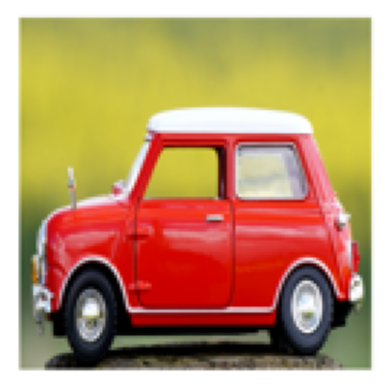

In [9]:
# load image in example/car.jpg and plot it

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms as transforms

image_path = "Voiture_Genia.png"
image = Image.open(image_path).convert("RGB")
image = image.resize((128, 128))

plt.imshow(image)
plt.axis("off")
plt.show()

image = transforms.ToTensor()(image).unsqueeze(0)  # Add batch dimension
image = image.to(diffusion_model.device)

# Etape 1 : Find eopt


In [10]:
prompt = "A yellow car"
device = "cuda"

timesteps = 1
alpha_t = 0.5

In [11]:
# This function is the first step (A) Optimize embedding and find eopt
def optimize_embeddings(input_image, target_text, diffusion_model, tokenizer, text_encoder, vae, scheduler, nb_step=1000):

  tokens = tokenizer(target_text, padding="max_length", truncation=True, return_tensors="pt")
  prompt_tokens = tokens.input_ids.to(device)


  # freeze embedding model parameters
  with torch.no_grad():
      etgt = text_encoder(prompt_tokens).last_hidden_state


  # Ici on initialise eopt (l'embedding a optimiser)
  eopt = etgt.clone().detach().requires_grad_(True)

  optimizer = optim.Adam([eopt], lr=2e-3)
  criterion = nn.MSELoss()


  # freeze diffusion model parameters
  for param in diffusion_model.parameters():
      param.requires_grad = False

  image = input_image.clone()

  # Permet de normaliser l'image (peut-être pas nécessaire)
  image_m1_1 = (image.to(device) * 2.0) - 1.0

  with torch.no_grad():
      image_latent = vae.encode(image_m1_1).latent_dist
      image_latent = image_latent.mean * vae.config.scaling_factor
      image_latent.to(device)
  free_memory()

  for i in range(nb_step):
      print("step " , i)
      noise_latent = torch.randn_like(image_latent)

      t = torch.randint(1, 50, size=(1,)).to(device)

      # Le scheduler permet d'ajouter du bruit t
      image_latent_noise = scheduler.add_noise(image_latent, noise_latent, t)

      # .sample permet de récupérer spécifiquement le tensor
      output = diffusion_model(image_latent_noise, t, encoder_hidden_states=eopt)
      noise_pred = output.sample

      noise_latent = scheduler.scale_model_input(noise_latent, t)

      # update embeddings
      optimizer.zero_grad()
      loss = criterion(noise_pred, noise_latent)
      loss.backward()
      optimizer.step()

  return (etgt, eopt)


etgt, eopt = optimize_embeddings(image, prompt, diffusion_model, tokenizer, text_encoder, vae, scheduler, nb_step=100)



VRAM utilisée: 4.29 Go
step  0
step  1
step  2
step  3
step  4
step  5
step  6
step  7
step  8
step  9
step  10
step  11
step  12
step  13
step  14
step  15
step  16
step  17
step  18
step  19
step  20
step  21
step  22
step  23
step  24
step  25
step  26
step  27
step  28
step  29
step  30
step  31
step  32
step  33
step  34
step  35
step  36
step  37
step  38
step  39
step  40
step  41
step  42
step  43
step  44
step  45
step  46
step  47
step  48
step  49
step  50
step  51
step  52
step  53
step  54
step  55
step  56
step  57
step  58
step  59
step  60
step  61
step  62
step  63
step  64
step  65
step  66
step  67
step  68
step  69
step  70
step  71
step  72
step  73
step  74
step  75
step  76
step  77
step  78
step  79
step  80
step  81
step  82
step  83
step  84
step  85
step  86
step  87
step  88
step  89
step  90
step  91
step  92
step  93
step  94
step  95
step  96
step  97
step  98
step  99


In [12]:
print(etgt)

tensor([[[-0.3884,  0.0229, -0.0522,  ..., -0.4899, -0.3066,  0.0675],
         [ 0.0290, -1.3258,  0.3085,  ..., -0.5257,  0.9768,  0.6652],
         [ 0.9568, -0.3391, -0.3438,  ...,  1.6478, -0.9793,  0.8329],
         ...,
         [ 0.8534, -0.2147, -0.9066,  ...,  0.0736,  0.3958, -0.4212],
         [ 0.8670, -0.2368, -0.8705,  ...,  0.0706,  0.3949, -0.3897],
         [ 0.8155, -0.1587, -0.8455,  ...,  0.0757,  0.4136, -0.4125]]],
       device='cuda:0')


In [13]:
print(eopt)

tensor([[[-0.5581,  0.1944,  0.1113,  ..., -0.3002, -0.2307,  0.1339],
         [-0.1305, -1.2809,  0.3443,  ..., -0.4269,  1.0812,  0.6673],
         [ 0.7916, -0.2080, -0.2198,  ...,  1.8230, -0.8124,  0.8855],
         ...,
         [ 0.9750, -0.2645, -0.9755,  ...,  0.1490,  0.5593, -0.2616],
         [ 0.9871, -0.2878, -0.9400,  ...,  0.1444,  0.5575, -0.2303],
         [ 0.9335, -0.2130, -0.9136,  ...,  0.1562,  0.5780, -0.2526]]],
       device='cuda:0', requires_grad=True)


# Etape 2

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm


def finetune_unet(
    input_image_0_1, # Image originale (tenseur 0-1)
    eopt,            
    unet,
    vae,             # Le VAE (pour encoder l'image)
    scheduler,       # Le scheduler (pour bruiter)
    device,
    num_steps=1500,
    lr=5e-7
):

    unet.train() # Met le modèle en mode entraînement
    for param in unet.parameters():
        param.requires_grad = True # S'assurer que les gradients sont activés


    # Optimizer pour Unet
    optimizer = optim.AdamW(unet.parameters(), lr=lr)
    criterion = nn.MSELoss()

    # Même chose que pour eopt
    image_m1_1 = (input_image_0_1.to(device) * 2.0) - 1.0

    # Pas besoin de modifier vae
    with torch.no_grad():
        encoded_dist = vae.encode(image_m1_1).latent_dist
        z0 = encoded_dist.mean * vae.config.scaling_factor
        
        
    # --- Boucle de Fine-tuning ---
    progress_bar = tqdm.tqdm(range(num_steps))
    for step in range(num_steps):
        print("step = ", step)
        optimizer.zero_grad()

        noise_latent = torch.randn_like(z0, device=device)
        t = torch.randint(0, scheduler.config.num_train_timesteps, (1,), device=device).long()

        zt = scheduler.add_noise(z0, noise_latent, t)
        output = unet(zt, t, encoder_hidden_states=eopt)
        noise_pred = output.sample

        # Calculate loss
        loss = criterion(noise_pred, noise_latent)

        # Backpropagate
        loss.backward()
        optimizer.step()

        progress_bar.update(1)
        progress_bar.set_postfix({"Loss": loss.item()})

    return unet




unet_fine_tuned = finetune_unet(
    image,
    eopt, # L'output de optimize_embeddings
    diffusion_model,
    vae,
    scheduler,
    device,
    num_steps=250,
    lr=5e-6
)


  0%|          | 0/250 [00:00<?, ?it/s]

step =  0


  1%|          | 2/250 [00:02<05:51,  1.42s/it, Loss=0.272]

step =  1


  1%|          | 2/250 [00:04<05:51,  1.42s/it, Loss=0.27] 

step =  2


  1%|          | 3/250 [00:06<07:20,  1.78s/it, Loss=0.0648]

step =  3


  2%|▏         | 4/250 [00:08<07:47,  1.90s/it, Loss=0.156] 

step =  4


  2%|▏         | 5/250 [00:11<08:07,  1.99s/it, Loss=0.199]

step =  5


  2%|▏         | 6/250 [00:13<08:18,  2.04s/it, Loss=0.0148]

step =  6


  3%|▎         | 8/250 [00:15<08:26,  2.09s/it, Loss=0.0452]

step =  7


  4%|▎         | 9/250 [00:17<08:27,  2.11s/it, Loss=0.212] 

step =  8


  4%|▍         | 10/250 [00:19<08:28,  2.12s/it, Loss=0.137]

step =  9


  4%|▍         | 10/250 [00:21<08:28,  2.12s/it, Loss=0.136]

step =  10


  5%|▍         | 12/250 [00:24<08:29,  2.14s/it, Loss=0.0281]

step =  11


  5%|▌         | 13/250 [00:26<08:30,  2.15s/it, Loss=0.00786]

step =  12


  5%|▌         | 13/250 [00:28<08:30,  2.15s/it, Loss=0.0136] 

step =  13


  6%|▌         | 14/250 [00:30<08:32,  2.17s/it, Loss=0.241] 

step =  14


  6%|▌         | 15/250 [00:32<08:26,  2.15s/it, Loss=0.251]

step =  15


  7%|▋         | 17/250 [00:34<08:24,  2.16s/it, Loss=0.181]

step =  16


  7%|▋         | 17/250 [00:36<08:24,  2.16s/it, Loss=0.0108]

step =  17


  7%|▋         | 18/250 [00:39<08:24,  2.17s/it, Loss=0.424] 

step =  18


  8%|▊         | 19/250 [00:41<08:25,  2.19s/it, Loss=0.0184]

step =  19


  8%|▊         | 21/250 [00:43<08:12,  2.15s/it, Loss=0.0278]

step =  20


  9%|▉         | 22/250 [00:45<08:08,  2.14s/it, Loss=0.161] 

step =  21


  9%|▉         | 23/250 [00:47<08:07,  2.15s/it, Loss=0.106]

step =  22


 10%|▉         | 24/250 [00:50<08:05,  2.15s/it, Loss=0.355]

step =  23


 10%|█         | 25/250 [00:52<08:03,  2.15s/it, Loss=0.093]

step =  24


 10%|█         | 25/250 [00:54<08:03,  2.15s/it, Loss=0.0325]

step =  25


 10%|█         | 26/250 [00:56<08:03,  2.16s/it, Loss=0.18]  

step =  26


 11%|█         | 28/250 [00:58<07:57,  2.15s/it, Loss=0.0372]

step =  27


 12%|█▏        | 29/250 [01:00<07:52,  2.14s/it, Loss=0.137] 

step =  28


 12%|█▏        | 30/250 [01:02<07:50,  2.14s/it, Loss=0.0052]

step =  29


 12%|█▏        | 31/250 [01:05<07:47,  2.13s/it, Loss=0.0654]

step =  30


 13%|█▎        | 32/250 [01:07<07:43,  2.13s/it, Loss=0.112] 

step =  31


 13%|█▎        | 33/250 [01:09<07:39,  2.12s/it, Loss=0.0288]

step =  32


 14%|█▎        | 34/250 [01:11<07:39,  2.13s/it, Loss=0.0705]

step =  33


 14%|█▎        | 34/250 [01:13<07:39,  2.13s/it, Loss=0.0162]

step =  34


 14%|█▍        | 35/250 [01:15<07:40,  2.14s/it, Loss=0.042] 

step =  35


 15%|█▍        | 37/250 [01:17<07:31,  2.12s/it, Loss=0.0751]

step =  36


 15%|█▍        | 37/250 [01:19<07:31,  2.12s/it, Loss=0.0456]

step =  37


 16%|█▌        | 39/250 [01:22<07:28,  2.13s/it, Loss=0.00305]

step =  38


 16%|█▌        | 40/250 [01:24<07:28,  2.14s/it, Loss=0.373]  

step =  39


 16%|█▌        | 40/250 [01:26<07:28,  2.14s/it, Loss=0.1]  

step =  40


 17%|█▋        | 42/250 [01:28<07:24,  2.14s/it, Loss=0.15]

step =  41


 17%|█▋        | 43/250 [01:30<07:24,  2.15s/it, Loss=0.0241]

step =  42


 18%|█▊        | 44/250 [01:32<07:22,  2.15s/it, Loss=0.00914]

step =  43


 18%|█▊        | 44/250 [01:34<07:22,  2.15s/it, Loss=0.00505]

step =  44


 18%|█▊        | 45/250 [01:36<07:25,  2.17s/it, Loss=0.268]  

step =  45


 18%|█▊        | 46/250 [01:39<07:19,  2.15s/it, Loss=0.0573]

step =  46


 19%|█▉        | 48/250 [01:41<07:12,  2.14s/it, Loss=0.0737]

step =  47


 20%|█▉        | 49/250 [01:43<07:09,  2.14s/it, Loss=0.238] 

step =  48


 20%|█▉        | 49/250 [01:45<07:09,  2.14s/it, Loss=0.0313]

step =  49


 20%|██        | 50/250 [01:47<07:10,  2.15s/it, Loss=0.1]   

step =  50


 20%|██        | 51/250 [01:49<07:08,  2.15s/it, Loss=0.0818]

step =  51


 21%|██        | 52/250 [01:52<07:11,  2.18s/it, Loss=0.0426]

step =  52


 21%|██        | 53/250 [01:54<07:06,  2.16s/it, Loss=0.153] 

step =  53


 22%|██▏       | 54/250 [01:56<07:01,  2.15s/it, Loss=0.265]

step =  54


 22%|██▏       | 56/250 [01:58<06:56,  2.15s/it, Loss=0.0251]

step =  55


 23%|██▎       | 57/250 [02:00<06:52,  2.14s/it, Loss=0.0901]

step =  56


 23%|██▎       | 58/250 [02:02<06:50,  2.14s/it, Loss=0.0596]

step =  57


 24%|██▎       | 59/250 [02:05<06:47,  2.13s/it, Loss=0.0425]

step =  58


 24%|██▎       | 59/250 [02:07<06:47,  2.13s/it, Loss=0.287] 

step =  59


 24%|██▍       | 61/250 [02:09<06:41,  2.13s/it, Loss=0.00906]

step =  60


 24%|██▍       | 61/250 [02:11<06:41,  2.13s/it, Loss=0.0743] 

step =  61


 25%|██▌       | 63/250 [02:13<06:37,  2.13s/it, Loss=0.273] 

step =  62


 26%|██▌       | 64/250 [02:15<06:35,  2.13s/it, Loss=0.135]

step =  63


 26%|██▌       | 65/250 [02:17<06:33,  2.13s/it, Loss=0.0181]

step =  64


 26%|██▋       | 66/250 [02:20<06:32,  2.13s/it, Loss=0.182] 

step =  65


 26%|██▋       | 66/250 [02:21<06:32,  2.13s/it, Loss=0.00413]

step =  66


 27%|██▋       | 67/250 [02:24<06:32,  2.15s/it, Loss=0.156]  

step =  67


 28%|██▊       | 69/250 [02:26<06:25,  2.13s/it, Loss=0.00584]

step =  68


 28%|██▊       | 69/250 [02:28<06:25,  2.13s/it, Loss=0.149]  

step =  69


 28%|██▊       | 71/250 [02:30<06:19,  2.12s/it, Loss=0.0426]

step =  70


 29%|██▉       | 72/250 [02:32<06:18,  2.12s/it, Loss=0.0436]

step =  71


 29%|██▉       | 72/250 [02:34<06:18,  2.12s/it, Loss=0.0042]

step =  72


 30%|██▉       | 74/250 [02:37<06:14,  2.13s/it, Loss=0.0822]

step =  73


 30%|███       | 75/250 [02:39<06:11,  2.13s/it, Loss=0.0323]

step =  74


 30%|███       | 75/250 [02:41<06:11,  2.13s/it, Loss=0.0686]

step =  75


 30%|███       | 76/250 [02:43<06:13,  2.15s/it, Loss=0.061] 

step =  76


 31%|███       | 78/250 [02:45<06:06,  2.13s/it, Loss=0.174]

step =  77


 32%|███▏      | 79/250 [02:47<06:04,  2.13s/it, Loss=0.016]

step =  78


 32%|███▏      | 79/250 [02:49<06:04,  2.13s/it, Loss=0.0664]

step =  79


 32%|███▏      | 81/250 [02:52<06:00,  2.14s/it, Loss=0.0201]

step =  80


 32%|███▏      | 81/250 [02:53<06:00,  2.14s/it, Loss=0.00526]

step =  81


 33%|███▎      | 82/250 [02:56<06:04,  2.17s/it, Loss=0.109]  

step =  82


 34%|███▎      | 84/250 [02:58<05:56,  2.15s/it, Loss=0.00688]

step =  83


 34%|███▎      | 84/250 [03:00<05:56,  2.15s/it, Loss=0.0953] 

step =  84


 34%|███▍      | 86/250 [03:02<05:52,  2.15s/it, Loss=0.0603]

step =  85


 35%|███▍      | 87/250 [03:04<05:50,  2.15s/it, Loss=0.00459]

step =  86


 35%|███▌      | 88/250 [03:07<05:48,  2.15s/it, Loss=0.0541] 

step =  87


 36%|███▌      | 89/250 [03:09<05:45,  2.14s/it, Loss=0.00193]

step =  88


 36%|███▌      | 90/250 [03:11<05:40,  2.13s/it, Loss=0.103]  

step =  89


 36%|███▋      | 91/250 [03:13<05:38,  2.13s/it, Loss=0.0189]

step =  90


 36%|███▋      | 91/250 [03:15<05:38,  2.13s/it, Loss=0.00172]

step =  91


 37%|███▋      | 93/250 [03:17<05:33,  2.12s/it, Loss=0.0803] 

step =  92


 37%|███▋      | 93/250 [03:19<05:33,  2.12s/it, Loss=0.00318]

step =  93


 38%|███▊      | 95/250 [03:22<05:29,  2.13s/it, Loss=0.0377] 

step =  94


 38%|███▊      | 95/250 [03:23<05:29,  2.13s/it, Loss=0.00831]

step =  95


 39%|███▉      | 97/250 [03:26<05:27,  2.14s/it, Loss=0.0223] 

step =  96


 39%|███▉      | 97/250 [03:28<05:27,  2.14s/it, Loss=0.00432]

step =  97


 39%|███▉      | 98/250 [03:30<05:29,  2.17s/it, Loss=0.0255] 

step =  98


 40%|████      | 100/250 [03:32<05:22,  2.15s/it, Loss=0.0151]

step =  99


 40%|████      | 100/250 [03:34<05:22,  2.15s/it, Loss=0.012] 

step =  100


 41%|████      | 102/250 [03:37<05:17,  2.15s/it, Loss=0.0824]

step =  101


 41%|████      | 102/250 [03:39<05:17,  2.15s/it, Loss=0.388] 

step =  102


 42%|████▏     | 104/250 [03:41<05:13,  2.15s/it, Loss=0.0449]

step =  103


 42%|████▏     | 104/250 [03:43<05:13,  2.15s/it, Loss=0.0238]

step =  104


 42%|████▏     | 105/250 [03:45<05:11,  2.15s/it, Loss=0.06]  

step =  105


 43%|████▎     | 107/250 [03:47<05:06,  2.15s/it, Loss=0.00677]

step =  106


 43%|████▎     | 107/250 [03:49<05:06,  2.15s/it, Loss=0.442]  

step =  107


 44%|████▎     | 109/250 [03:52<05:01,  2.14s/it, Loss=0.00597]

step =  108


 44%|████▎     | 109/250 [03:54<05:01,  2.14s/it, Loss=0.00212]

step =  109


 44%|████▍     | 111/250 [03:56<04:58,  2.14s/it, Loss=0.0144] 

step =  110


 45%|████▍     | 112/250 [03:58<04:56,  2.15s/it, Loss=0.0321]

step =  111


 45%|████▌     | 113/250 [04:00<04:52,  2.14s/it, Loss=0.192] 

step =  112


 46%|████▌     | 114/250 [04:02<04:51,  2.15s/it, Loss=0.0154]

step =  113


 46%|████▌     | 114/250 [04:04<04:51,  2.15s/it, Loss=0.0539]

step =  114


 46%|████▋     | 116/250 [04:07<04:45,  2.13s/it, Loss=0.034] 

step =  115


 47%|████▋     | 117/250 [04:09<04:42,  2.12s/it, Loss=0.00222]

step =  116


 47%|████▋     | 117/250 [04:11<04:42,  2.12s/it, Loss=0.0109] 

step =  117


 47%|████▋     | 118/250 [04:13<04:41,  2.13s/it, Loss=0.0666]

step =  118


 48%|████▊     | 120/250 [04:15<04:36,  2.13s/it, Loss=0.00448]

step =  119


 48%|████▊     | 121/250 [04:17<04:34,  2.13s/it, Loss=0.0207] 

step =  120


 49%|████▉     | 122/250 [04:19<04:33,  2.14s/it, Loss=0.00699]

step =  121


 49%|████▉     | 123/250 [04:22<04:31,  2.14s/it, Loss=0.115]  

step =  122


 50%|████▉     | 124/250 [04:24<04:29,  2.14s/it, Loss=0.0236]

step =  123


 50%|████▉     | 124/250 [04:26<04:29,  2.14s/it, Loss=0.195] 

step =  124


 50%|█████     | 126/250 [04:28<04:25,  2.14s/it, Loss=0.359]

step =  125


 50%|█████     | 126/250 [04:30<04:25,  2.14s/it, Loss=0.0213]

step =  126


 51%|█████     | 128/250 [04:32<04:20,  2.14s/it, Loss=0.0583]

step =  127


 51%|█████     | 128/250 [04:34<04:20,  2.14s/it, Loss=0.0251]

step =  128


 52%|█████▏    | 129/250 [04:36<04:19,  2.15s/it, Loss=0.00518]

step =  129


 52%|█████▏    | 130/250 [04:39<04:20,  2.17s/it, Loss=0.00335]

step =  130


 53%|█████▎    | 132/250 [04:41<04:13,  2.15s/it, Loss=0.0455] 

step =  131


 53%|█████▎    | 132/250 [04:43<04:13,  2.15s/it, Loss=0.00267]

step =  132


 54%|█████▎    | 134/250 [04:45<04:10,  2.16s/it, Loss=0.015]  

step =  133


 54%|█████▍    | 135/250 [04:47<04:09,  2.17s/it, Loss=0.00506]

step =  134


 54%|█████▍    | 136/250 [04:50<04:07,  2.17s/it, Loss=0.0254] 

step =  135


 54%|█████▍    | 136/250 [04:52<04:07,  2.17s/it, Loss=0.0068]

step =  136


 55%|█████▍    | 137/250 [04:54<04:06,  2.18s/it, Loss=0.0123]

step =  137


 56%|█████▌    | 139/250 [04:56<04:00,  2.16s/it, Loss=0.134] 

step =  138


 56%|█████▌    | 140/250 [04:58<03:56,  2.15s/it, Loss=0.0234]

step =  139


 56%|█████▋    | 141/250 [05:00<03:53,  2.14s/it, Loss=0.00913]

step =  140


 57%|█████▋    | 142/250 [05:03<03:51,  2.14s/it, Loss=0.00696]

step =  141


 57%|█████▋    | 143/250 [05:05<03:48,  2.13s/it, Loss=0.00824]

step =  142


 58%|█████▊    | 144/250 [05:07<03:45,  2.12s/it, Loss=0.0692] 

step =  143


 58%|█████▊    | 145/250 [05:09<03:42,  2.12s/it, Loss=0.00661]

step =  144


 58%|█████▊    | 145/250 [05:11<03:42,  2.12s/it, Loss=0.0116] 

step =  145


 58%|█████▊    | 146/250 [05:13<03:42,  2.14s/it, Loss=0.154] 

step =  146


 59%|█████▉    | 148/250 [05:15<03:36,  2.13s/it, Loss=0.00517]

step =  147


 60%|█████▉    | 149/250 [05:17<03:33,  2.12s/it, Loss=0.00378]

step =  148


 60%|█████▉    | 149/250 [05:19<03:33,  2.12s/it, Loss=0.00943]

step =  149


 60%|██████    | 151/250 [05:22<03:30,  2.13s/it, Loss=0.0141] 

step =  150


 60%|██████    | 151/250 [05:24<03:30,  2.13s/it, Loss=0.00429]

step =  151


 61%|██████    | 152/250 [05:26<03:28,  2.13s/it, Loss=0.00684]

step =  152


 62%|██████▏   | 154/250 [05:28<03:24,  2.13s/it, Loss=0.00231]

step =  153


 62%|██████▏   | 155/250 [05:30<03:22,  2.13s/it, Loss=0.0114] 

step =  154


 62%|██████▏   | 155/250 [05:32<03:22,  2.13s/it, Loss=0.00186]

step =  155


 63%|██████▎   | 157/250 [05:34<03:18,  2.13s/it, Loss=0.0196] 

step =  156


 63%|██████▎   | 158/250 [05:37<03:16,  2.14s/it, Loss=0.038] 

step =  157


 63%|██████▎   | 158/250 [05:39<03:16,  2.14s/it, Loss=0.0123]

step =  158


 64%|██████▍   | 160/250 [05:41<03:12,  2.13s/it, Loss=0.0178]

step =  159


 64%|██████▍   | 160/250 [05:43<03:12,  2.13s/it, Loss=0.00674]

step =  160


 64%|██████▍   | 161/250 [05:45<03:11,  2.15s/it, Loss=0.143]  

step =  161


 65%|██████▍   | 162/250 [05:47<03:09,  2.16s/it, Loss=0.0775]

step =  162


 66%|██████▌   | 164/250 [05:49<03:03,  2.13s/it, Loss=0.00468]

step =  163


 66%|██████▌   | 164/250 [05:51<03:03,  2.13s/it, Loss=0.00412]

step =  164


 66%|██████▋   | 166/250 [05:54<02:59,  2.14s/it, Loss=0.0162] 

step =  165


 67%|██████▋   | 167/250 [05:56<02:57,  2.14s/it, Loss=0.0035]

step =  166


 67%|██████▋   | 167/250 [05:58<02:57,  2.14s/it, Loss=0.032] 

step =  167


 67%|██████▋   | 168/250 [06:00<02:56,  2.15s/it, Loss=0.0432]

step =  168


 68%|██████▊   | 170/250 [06:02<02:50,  2.13s/it, Loss=0.0016]

step =  169


 68%|██████▊   | 171/250 [06:04<02:48,  2.13s/it, Loss=0.0131]

step =  170


 69%|██████▉   | 172/250 [06:07<02:45,  2.12s/it, Loss=0.0014]

step =  171


 69%|██████▉   | 173/250 [06:09<02:43,  2.12s/it, Loss=0.0298]

step =  172


 70%|██████▉   | 174/250 [06:11<02:41,  2.13s/it, Loss=0.0234]

step =  173


 70%|███████   | 175/250 [06:13<02:39,  2.13s/it, Loss=0.0423]

step =  174


 70%|███████   | 176/250 [06:15<02:37,  2.13s/it, Loss=0.015] 

step =  175


 70%|███████   | 176/250 [06:17<02:37,  2.13s/it, Loss=0.0243]

step =  176


 71%|███████   | 177/250 [06:19<02:35,  2.13s/it, Loss=0.0366]

step =  177


 72%|███████▏  | 179/250 [06:21<02:31,  2.13s/it, Loss=0.0133]

step =  178


 72%|███████▏  | 180/250 [06:24<02:29,  2.13s/it, Loss=0.00232]

step =  179


 72%|███████▏  | 180/250 [06:26<02:29,  2.13s/it, Loss=0.0451] 

step =  180


 73%|███████▎  | 182/250 [06:28<02:25,  2.14s/it, Loss=0.0322]

step =  181


 73%|███████▎  | 183/250 [06:30<02:24,  2.15s/it, Loss=0.0027]

step =  182


 73%|███████▎  | 183/250 [06:32<02:24,  2.15s/it, Loss=0.00119]

step =  183


 74%|███████▍  | 185/250 [06:34<02:18,  2.13s/it, Loss=0.00217]

step =  184


 74%|███████▍  | 185/250 [06:36<02:18,  2.13s/it, Loss=0.00503]

step =  185


 75%|███████▍  | 187/250 [06:39<02:15,  2.15s/it, Loss=0.00618]

step =  186


 75%|███████▌  | 188/250 [06:41<02:12,  2.14s/it, Loss=0.00258]

step =  187


 75%|███████▌  | 188/250 [06:43<02:12,  2.14s/it, Loss=0.0252] 

step =  188


 76%|███████▌  | 190/250 [06:45<02:08,  2.15s/it, Loss=0.0082]

step =  189


 76%|███████▋  | 191/250 [06:47<02:06,  2.15s/it, Loss=0.0362]

step =  190


 77%|███████▋  | 192/250 [06:49<02:04,  2.14s/it, Loss=0.0173]

step =  191


 77%|███████▋  | 192/250 [06:51<02:04,  2.14s/it, Loss=0.0108]

step =  192


 77%|███████▋  | 193/250 [06:54<02:02,  2.15s/it, Loss=0.044] 

step =  193


 78%|███████▊  | 194/250 [06:56<02:00,  2.15s/it, Loss=0.0213]

step =  194


 78%|███████▊  | 195/250 [06:58<01:59,  2.17s/it, Loss=0.127] 

step =  195


 79%|███████▉  | 197/250 [07:00<01:53,  2.15s/it, Loss=0.00246]

step =  196


 79%|███████▉  | 197/250 [07:02<01:53,  2.15s/it, Loss=0.00981]

step =  197


 80%|███████▉  | 199/250 [07:04<01:48,  2.14s/it, Loss=0.00151]

step =  198


 80%|███████▉  | 199/250 [07:06<01:48,  2.14s/it, Loss=0.00528]

step =  199


 80%|████████  | 201/250 [07:09<01:44,  2.14s/it, Loss=0.0145] 

step =  200


 80%|████████  | 201/250 [07:11<01:44,  2.14s/it, Loss=0.0351]

step =  201


 81%|████████  | 202/250 [07:13<01:43,  2.16s/it, Loss=0.0285]

step =  202


 81%|████████  | 203/250 [07:15<01:40,  2.14s/it, Loss=0.00642]

step =  203


 82%|████████▏ | 205/250 [07:17<01:36,  2.14s/it, Loss=0.00972]

step =  204


 82%|████████▏ | 206/250 [07:19<01:34,  2.15s/it, Loss=0.00202]

step =  205


 83%|████████▎ | 207/250 [07:22<01:32,  2.15s/it, Loss=0.0225] 

step =  206


 83%|████████▎ | 207/250 [07:24<01:32,  2.15s/it, Loss=0.194] 

step =  207


 83%|████████▎ | 208/250 [07:26<01:30,  2.15s/it, Loss=0.0159]

step =  208


 84%|████████▎ | 209/250 [07:28<01:28,  2.16s/it, Loss=0.00273]

step =  209


 84%|████████▍ | 210/250 [07:30<01:25,  2.15s/it, Loss=0.00441]

step =  210


 85%|████████▍ | 212/250 [07:32<01:21,  2.14s/it, Loss=0.00101]

step =  211


 85%|████████▍ | 212/250 [07:34<01:21,  2.14s/it, Loss=0.00211]

step =  212


 86%|████████▌ | 214/250 [07:37<01:16,  2.14s/it, Loss=0.00144]

step =  213


 86%|████████▌ | 215/250 [07:39<01:15,  2.15s/it, Loss=0.0019] 

step =  214


 86%|████████▋ | 216/250 [07:41<01:12,  2.15s/it, Loss=0.0107]

step =  215


 86%|████████▋ | 216/250 [07:43<01:12,  2.15s/it, Loss=0.00107]

step =  216


 87%|████████▋ | 218/250 [07:45<01:08,  2.13s/it, Loss=0.0104] 

step =  217


 87%|████████▋ | 218/250 [07:47<01:08,  2.13s/it, Loss=0.0138]

step =  218


 88%|████████▊ | 219/250 [07:49<01:06,  2.15s/it, Loss=0.00547]

step =  219


 88%|████████▊ | 220/250 [07:52<01:04,  2.15s/it, Loss=0.00522]

step =  220


 89%|████████▉ | 222/250 [07:54<00:59,  2.14s/it, Loss=0.0104] 

step =  221


 89%|████████▉ | 222/250 [07:56<00:59,  2.14s/it, Loss=0.00251]

step =  222


 90%|████████▉ | 224/250 [07:58<00:55,  2.14s/it, Loss=0.0432] 

step =  223


 90%|█████████ | 225/250 [08:00<00:53,  2.14s/it, Loss=0.0733]

step =  224


 90%|█████████ | 225/250 [08:02<00:53,  2.14s/it, Loss=0.00285]

step =  225


 91%|█████████ | 227/250 [08:05<00:49,  2.14s/it, Loss=0.0223] 

step =  226


 91%|█████████ | 228/250 [08:07<00:46,  2.13s/it, Loss=0.0108]

step =  227


 91%|█████████ | 228/250 [08:09<00:46,  2.13s/it, Loss=0.00404]

step =  228


 92%|█████████▏| 230/250 [08:11<00:42,  2.12s/it, Loss=0.0554] 

step =  229


 92%|█████████▏| 230/250 [08:13<00:42,  2.12s/it, Loss=0.026] 

step =  230


 93%|█████████▎| 232/250 [08:15<00:38,  2.12s/it, Loss=0.0455]

step =  231


 93%|█████████▎| 233/250 [08:17<00:36,  2.13s/it, Loss=0.0219]

step =  232


 93%|█████████▎| 233/250 [08:19<00:36,  2.13s/it, Loss=0.0424]

step =  233


 94%|█████████▍| 235/250 [08:22<00:32,  2.14s/it, Loss=0.0121]

step =  234


 94%|█████████▍| 236/250 [08:24<00:29,  2.14s/it, Loss=0.00693]

step =  235


 94%|█████████▍| 236/250 [08:26<00:29,  2.14s/it, Loss=0.0108] 

step =  236


 95%|█████████▌| 238/250 [08:28<00:25,  2.14s/it, Loss=0.00217]

step =  237


 95%|█████████▌| 238/250 [08:30<00:25,  2.14s/it, Loss=0.011]  

step =  238


 96%|█████████▌| 239/250 [08:32<00:23,  2.15s/it, Loss=0.00923]

step =  239


 96%|█████████▌| 240/250 [08:34<00:21,  2.16s/it, Loss=0.0166] 

step =  240


 96%|█████████▋| 241/250 [08:37<00:19,  2.17s/it, Loss=0.00978]

step =  241


 97%|█████████▋| 243/250 [08:39<00:15,  2.15s/it, Loss=0.00324]

step =  242


 97%|█████████▋| 243/250 [08:41<00:15,  2.15s/it, Loss=0.0226] 

step =  243


 98%|█████████▊| 245/250 [08:43<00:10,  2.15s/it, Loss=0.0127]

step =  244


 98%|█████████▊| 246/250 [08:45<00:08,  2.15s/it, Loss=0.00224]

step =  245


 98%|█████████▊| 246/250 [08:47<00:08,  2.15s/it, Loss=0.00373]

step =  246


 99%|█████████▉| 248/250 [08:50<00:04,  2.14s/it, Loss=0.00162]

step =  247


 99%|█████████▉| 248/250 [08:52<00:04,  2.14s/it, Loss=0.0336] 

step =  248


100%|██████████| 250/250 [08:54<00:00,  2.14s/it, Loss=0.00253]

step =  249


100%|██████████| 250/250 [08:56<00:00,  2.15s/it, Loss=0.00138]


# Etape 3

In [15]:

def interpolate_embeddings(etgt, eopt, eta):

  e_interpolated = eta * etgt + (1 - eta) * eopt

  return e_interpolated

interpolation_factor_eta = 0.7
e_interpolated = interpolate_embeddings(etgt, eopt, eta=interpolation_factor_eta)


# Script permettant d'observer la prédiction du modèle avec etbt après optimisation  

##  (A utiliser uniquement pour le rapport)

Starting denoising loop...


  0%|          | 0/51 [00:00<?, ?it/s]

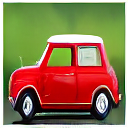

In [16]:
import torch
from PIL import Image
import numpy as np
from tqdm.auto import tqdm

@torch.no_grad()
def generate_with_eopt(input_image, eopt, unet, scheduler, vae, device, height=512, width=512, num_inference_steps=50):

    image_m1_1 = (input_image * 2.0) - 1.0

    with torch.no_grad():
        image_latent = vae.encode(image_m1_1).latent_dist
        latents = image_latent.mean * vae.config.scaling_factor
        latents.to(device)

    # Génération a partir de bruit
    latents = torch.randn_like(latents)

    # 3. Définir les timesteps
    scheduler.set_timesteps(num_inference_steps)
    timesteps = scheduler.timesteps.to(device)


    # Boucle pour enlever le bruit
    print("Starting denoising loop...")
    for t in tqdm(timesteps):
        latent_model_input = scheduler.scale_model_input(latents, t) # Mise à l'échelle si besoin

        noise_pred = unet(latent_model_input, t, encoder_hidden_states=eopt).sample
        latents = scheduler.step(noise_pred, t, latents).prev_sample


    # Passer de l'espace latent à l'image réelle
    latents = latents / vae.config.scaling_factor
    image_pixels = vae.decode(latents).sample

    image_pixels = (image_pixels / 2 + 0.5).clamp(0, 1) # Remap [-1, 1] -> [0, 1]
    image_pixels = image_pixels.cpu().permute(0, 2, 3, 1).numpy() # Format [Batch, H, W, C] pour PIL
    image_pil = Image.fromarray((image_pixels[0] * 255).astype(np.uint8)) # Prend la 1ere image du batch

    return image_pil


generate_with_eopt(image, e_interpolated, unet_fine_tuned, scheduler, vae, device="cuda", height=128, width=128, num_inference_steps=50)

# Test


In [17]:
import torch
from PIL import Image
import numpy as np
from tqdm.auto import tqdm

@torch.no_grad()
def generate_with_eopt(eopt, unet, scheduler, vae, device, height=512, width=512, num_inference_steps=50, guidance_scale=7.5, seed=None): # Removed input_image from args
    """Génère une image en utilisant l'embedding optimisé eopt, en partant de bruit."""

    # --- Initial Setup ---
    if seed is not None:
        generator = torch.Generator(device=device).manual_seed(seed)
    else:
        generator = None

    unet = unet.to(device).eval()
    vae = vae.to(device).eval()
    eopt = eopt.to(device)

    # --- 1. Initialisation du Bruit Latent ---
    # PAS d'encodage de l'image d'entrée ici.
    # image_m1_1 = (input_image * 2.0) - 1.0 # ERREUR : Supprimé
    # with torch.no_grad(): # ERREUR : Supprimé
    #     image_latent = vae.encode(image_m1_1).latent_dist # ERREUR : Supprimé
    #     latents = image_latent.mean * vae.config.scaling_factor # ERREUR : Supprimé
    #     latents.to(device) # ERREUR : Supprimé

    # CORRECTION : Créer bruit aléatoire
    latent_height = height // 8
    latent_width = width // 8
    latent_channels = unet.config.in_channels
    latent_shape = (1, latent_channels, latent_height, latent_width)
    latents = torch.randn(latent_shape, generator=generator, device=device, dtype=unet.dtype)
    print(f"Initial random latents shape: {latents.shape}, Device: {latents.device}")


    # --- 2. Préparer le Scheduler ---
    scheduler.set_timesteps(num_inference_steps)
    timesteps = scheduler.timesteps.to(device) # OK

    # Mise à l'échelle initiale du bruit (important !)
    latents = latents * scheduler.init_noise_sigma # OK


    # --- ERREUR : Ligne ajoutée incorrecte ---
    # noise_latent = torch.randn_like(latents) # ERREUR : Bruit redondant
    # latents = diffusion_model(noise_latent, timesteps, encoder_hidden_states=eopt).to(device) # ERREUR : Conceptuellement faux
    # Cette ligne essayait d'appeler le modèle sur du bruit pur avec *tous* les timesteps en même temps ?
    # Elle court-circuitait complètement la boucle de débruitage itératif. Supprimée.


    # --- 3. Boucle de Débruitage ---
    print("Starting denoising loop...")
    for t in tqdm(timesteps):
        # Pas de guidance nécessaire ici
        latent_model_input = scheduler.scale_model_input(latents, t) # OK (Mise à l'échelle si besoin)

        # Prédire le bruit avec le UNet
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=eopt).sample # OK

        # Calculer l'état précédent avec le scheduler
        latents = scheduler.step(noise_pred, t, latents).prev_sample # OK
    print("Denoising finished.")


    # --- 4. Décoder l'Image Latente Finale ---
    latents = latents / vae.config.scaling_factor # OK
    print("Decoding final latents...")
    image_pixels = vae.decode(latents).sample # OK

    # --- 5. Post-traitement ---
    image_pixels = (image_pixels / 2 + 0.5).clamp(0, 1) # OK
    image_pixels = image_pixels.cpu().permute(0, 2, 3, 1).numpy() # OK
    image_pil = Image.fromarray((image_pixels[0] * 255).astype(np.uint8)) # OK

    return image_pil


# --- Appel ---
# Assurez-vous que 'eopt' est l'embedding optimisé et DÉTACHÉ
# Assurez-vous que 'unet' (diffusion_model dans l'appel original), 'scheduler', 'vae' sont chargés
# Assurez-vous que 'device' est défini

# image_result = generate_with_eopt(eopt, unet, scheduler, vae, device, num_inference_steps=50, seed=42)
# image_result.show()

# Example generation Text-Image



In [18]:
import torch
from diffusers import StableDiffusionPipeline

model_id = "stable-diffusion-v1-5/stable-diffusion-v1-5"
device = "cuda"


pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipe = pipe.to(device)

prompt = "An astronaut riding horse in Mars"
image = pipe(prompt).images[0]

image.save("astronaut_rides_horse.png")


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]